# Ames Housing Feature Engineering

1. Missing values
2. Temporal variables
3. Non-Gaussian distributed variables
4. Categorical variables: remove rare labels
5. Categorical variables: convert strings to numbers
5. Put the variables in a similar scale

With the aim to ensure reproducibility between runs of the same notebook, and between the research and production environment, for each step that includes some element of randomness, it is extremely important that **the seed** is set.

## Libraries and packages

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for the yeo-johnson transformation
import scipy.stats as stats

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to save the trained scaler class
import joblib

# to visualise al the columns in the dataframe
pd.pandas.set_option("display.max_columns", None)

## Paths

In [2]:
# Path to datasets directory
data_path = "./datasets"
# Path to assets directory (for saving results to)
assets_path = "./assets"

## Loading dataset

In [3]:
data = pd.read_csv(f"{data_path}/train.csv")

print(data.shape)
data.head()

(1460, 81)


Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

## Separate dataset into train and test

When engineering features, some techniques learn parameters from data. It is important to learn these parameters only from the train set to avoid over-fitting.

Feature engineering techniques:

- mean
- mode
- exponents for the yeo-johnson
- category frequency
- and category to number mappings

**Separating the data into train and test involves randomness. Set the seed.**

In [4]:
# Separate into train and test set and set the seed
# (random_state for this sklearn function)

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(["Id", "SalePrice"], axis=1),  # predictive variables
    data["SalePrice"],  # target
    test_size=0.1,  # portion of dataset to allocate to test set
    random_state=0,  # we are setting the seed here
)

X_train.shape, X_test.shape

((1314, 79), (146, 79))

## Target

Apply the logarithm (see EDA)

In [5]:
y_train = np.log(y_train)
y_test = np.log(y_test)

## Missing values

### Categorical variables

Replacing missing values with the string "missing" in variables with a lot of missing data.

Alternatively, replacing missing data with the most frequent category in those variables that contain fewer observations without values.

In [6]:
# Identifying the categorical variables (type object)

cat_vars = [var for var in data.columns if data[var].dtype == "O"]

# MSSubClass is also categorical by definition, despite its numeric values
# (you can find the definitions of the variables in the data_description.txt
# file available on Kaggle, in the same website where you downloaded the data)

# Add MSSubClass to the list of categorical variables
cat_vars = cat_vars + ["MSSubClass"]

# cast categorical
X_train[cat_vars] = X_train[cat_vars].astype("O")
X_test[cat_vars] = X_test[cat_vars].astype("O")

# number of categorical variables
len(cat_vars)

44

In [7]:
# List of the categorical variables that contain missing values
cat_vars_with_na = [var for var in cat_vars if X_train[var].isnull().sum() > 0]

# print percentage of missing values per variable
X_train[cat_vars_with_na].isnull().mean().sort_values(ascending=False)

PoolQC          0.995434
MiscFeature     0.961187
Alley           0.938356
Fence           0.814307
FireplaceQu     0.472603
GarageType      0.056317
GarageFinish    0.056317
GarageQual      0.056317
GarageCond      0.056317
BsmtExposure    0.025114
BsmtFinType2    0.025114
BsmtQual        0.024353
BsmtCond        0.024353
BsmtFinType1    0.024353
MasVnrType      0.004566
Electrical      0.000761
dtype: float64

In [8]:
# variables to impute with the string missing
with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() > 0.1
]

# variables to impute with the most frequent category
with_frequent_category = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean() < 0.1
]

In [9]:
with_string_missing

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [10]:
# Replacing missing values with new label: "Missing"
X_train[with_string_missing] = X_train[with_string_missing].fillna("Missing")
X_test[with_string_missing] = X_test[with_string_missing].fillna("Missing")

In [11]:
for var in with_frequent_category:

    # there can be more than 1 mode in a variable
    # we take the first one with [0]
    mode = X_train[var].mode()[0]

    print(var, mode)

    X_train[var].fillna(mode, inplace=True)
    X_test[var].fillna(mode, inplace=True)

MasVnrType None
BsmtQual TA
BsmtCond TA
BsmtExposure No
BsmtFinType1 Unf
BsmtFinType2 Unf
Electrical SBrkr
GarageType Attchd
GarageFinish Unf
GarageQual TA
GarageCond TA


In [12]:
# check that no missing information in the engineered variables
X_train[cat_vars_with_na].isnull().sum()

Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [13]:
# check test set does not contain null values in the engineered variables
[var for var in cat_vars_with_na if X_test[var].isnull().sum() > 0]

[]

### Numerical variables

To engineer missing values in numerical variables:

- add a binary missing indicator variable
- and then replace the missing values in the original variable with the mean

In [14]:
# Identifying the numerical variables
num_vars = [
    var
    for var in X_train.columns
    if var not in cat_vars and var != "SalePrice"
]

# number of numerical variables
len(num_vars)

35

In [15]:
# List with the numerical variables that contain missing values
vars_with_na = [var for var in num_vars if X_train[var].isnull().sum() > 0]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

LotFrontage    0.177321
MasVnrArea     0.004566
GarageYrBlt    0.056317
dtype: float64

In [16]:
# Replacing missing values as described above
for var in vars_with_na:

    # calculate the mean using the train set
    mean_val = X_train[var].mean()

    print(var, mean_val)

    # add binary missing indicator (in train and test)
    X_train[var + "_na"] = np.where(X_train[var].isnull(), 1, 0)
    X_test[var + "_na"] = np.where(X_test[var].isnull(), 1, 0)

    # replace missing values by the mean
    # (in train and test)
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)

# check no more missing values in the engineered variables
X_train[vars_with_na].isnull().sum()

LotFrontage 69.87974098057354
MasVnrArea 103.7974006116208
GarageYrBlt 1978.2959677419356


LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [17]:
# check test set does not contain null values in the engineered variables
[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

In [18]:
# check the binary missing indicator variables
X_train[["LotFrontage_na", "MasVnrArea_na", "GarageYrBlt_na"]].head()

LotFrontage_na  MasVnrArea_na  GarageYrBlt_na
930                0              0               0
656                0              0               0
45                 0              0               0
1348               1              0               0
55                 0              0               0

## Temporal variables

### Capture elapsed time

From EDA, there are 4 variables that refer to the years in which the house or the garage were built or remodeled. Capturing the time elapsed between those variables and the year in which the house was sold:

In [19]:
def elapsed_years(df, var):
    # capture difference between the year variable
    # and the year in which the house was sold
    df[var] = df["YrSold"] - df[var]
    return df

In [20]:
for var in ["YearBuilt", "YearRemodAdd", "GarageYrBlt"]:
    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [21]:
# now drop YrSold
X_train.drop(["YrSold"], axis=1, inplace=True)
X_test.drop(["YrSold"], axis=1, inplace=True)

## Numerical variable transformation

### Logarithmic transformation

From EDA, the numerical variables are not normally distributed. Transforming the positive numerical variables with the logarithm in order to get more Gaussian-like distributions.

In [22]:
for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

In [23]:
# check test set does not contain null values in the engineered variables
[
    var
    for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]
    if X_test[var].isnull().sum() > 0
]

[]

In [24]:
# same for train set
[
    var
    for var in ["LotFrontage", "1stFlrSF", "GrLivArea"]
    if X_train[var].isnull().sum() > 0
]

[]

### Yeo-Johnson transformation

Applying the Yeo-Johnson transformation to LotArea.

In [25]:
# the yeo-johnson transformation learns the best exponent to transform
# the variable it needs to learn it from the train set:
X_train["LotArea"], param = stats.yeojohnson(X_train["LotArea"])

# and then apply the transformation to the test set with the same
# parameter: see who this time we pass param as argument to the
# yeo-johnson
X_test["LotArea"] = stats.yeojohnson(X_test["LotArea"], lmbda=param)

print(param)

0.017755553920094667


In [26]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [27]:
# check absence of na in the test set
[var for var in X_train.columns if X_test[var].isnull().sum() > 0]

[]

### Binarize skewed variables

A few variables were very skewed, transforming into binary variables.

In [28]:
skewed = [
    "BsmtFinSF2",
    "LowQualFinSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "MiscVal",
]

for var in skewed:

    # map the variable values into 0 and 1
    X_train[var] = np.where(X_train[var] == 0, 0, 1)
    X_test[var] = np.where(X_test[var] == 0, 0, 1)

## Categorical variables

### Apply mappings

In [29]:
# Re-mapping string to number (determine quality)
qual_mappings = {
    "Po": 1,
    "Fa": 2,
    "TA": 3,
    "Gd": 4,
    "Ex": 5,
    "Missing": 0,
    "NA": 0,
}

qual_vars = [
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "HeatingQC",
    "KitchenQual",
    "FireplaceQu",
    "GarageQual",
    "GarageCond",
]

for var in qual_vars:
    X_train[var] = X_train[var].map(qual_mappings)
    X_test[var] = X_test[var].map(qual_mappings)

In [30]:
exposure_mappings = {"No": 1, "Mn": 2, "Av": 3, "Gd": 4}

var = "BsmtExposure"

X_train[var] = X_train[var].map(exposure_mappings)
X_test[var] = X_test[var].map(exposure_mappings)

In [31]:
finish_mappings = {
    "Missing": 0,
    "NA": 0,
    "Unf": 1,
    "LwQ": 2,
    "Rec": 3,
    "BLQ": 4,
    "ALQ": 5,
    "GLQ": 6,
}

finish_vars = ["BsmtFinType1", "BsmtFinType2"]

for var in finish_vars:
    X_train[var] = X_train[var].map(finish_mappings)
    X_test[var] = X_test[var].map(finish_mappings)

In [32]:
garage_mappings = {"Missing": 0, "NA": 0, "Unf": 1, "RFn": 2, "Fin": 3}

var = "GarageFinish"

X_train[var] = X_train[var].map(garage_mappings)
X_test[var] = X_test[var].map(garage_mappings)

In [33]:
fence_mappings = {
    "Missing": 0,
    "NA": 0,
    "MnWw": 1,
    "GdWo": 2,
    "MnPrv": 3,
    "GdPrv": 4,
}

var = "Fence"

X_train[var] = X_train[var].map(fence_mappings)
X_test[var] = X_test[var].map(fence_mappings)

In [34]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

### Removing Rare Labels

Grouping the remaining categorical variables present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of houses, will be replaced by the string "Rare".

In [35]:
# Capturing all quality variables
qual_vars = qual_vars + finish_vars + ["BsmtExposure", "GarageFinish", "Fence"]

# Capturing the remaining categorical variables
# (those that were not re-mapped)

cat_others = [var for var in cat_vars if var not in qual_vars]

len(cat_others)

30

In [36]:
def find_frequent_labels(df, var, rare_perc):

    # function finds the labels that are shared by more than
    # a certain % of the houses in the dataset

    df = df.copy()

    tmp = df.groupby(var)[var].count() / len(df)

    return tmp[tmp > rare_perc].index


for var in cat_others:

    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)

    print(var, frequent_ls)
    print()

    # replace rare categories by the string "Rare"
    X_train[var] = np.where(
        X_train[var].isin(frequent_ls), X_train[var], "Rare"
    )

    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], "Rare")

MSZoning Index(['FV', 'RH', 'RL', 'RM'], dtype='object', name='MSZoning')

Street Index(['Pave'], dtype='object', name='Street')

Alley Index(['Grvl', 'Missing', 'Pave'], dtype='object', name='Alley')

LotShape Index(['IR1', 'IR2', 'Reg'], dtype='object', name='LotShape')

LandContour Index(['Bnk', 'HLS', 'Low', 'Lvl'], dtype='object', name='LandContour')

Utilities Index(['AllPub'], dtype='object', name='Utilities')

LotConfig Index(['Corner', 'CulDSac', 'FR2', 'Inside'], dtype='object', name='LotConfig')

LandSlope Index(['Gtl', 'Mod'], dtype='object', name='LandSlope')

Neighborhood Index(['Blmngtn', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor',
       'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes',
       'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW',
       'Somerst', 'StoneBr', 'Timber'],
      dtype='object', name='Neighborhood')

Condition1 Index(['Artery', 'Feedr', 'Norm', 'PosN', 'RRAn'], dtype='object', name='Condition1')

Con

### Encoding of categorical variables

Next, we need to transform the strings of the categorical variables into numbers. 

We will do it so that we capture the monotonic relationship between the label and the target.

To learn more about how to encode categorical variables visit our course [Feature Engineering for Machine Learning](https://www.udemy.com/course/feature-engineering-for-machine-learning/?referralCode=A855148E05283015CF06) in Udemy.

In [37]:
# this function will assign discrete values to the strings of the variables,
# so that the smaller value corresponds to the category that shows the smaller
# mean house sale price


def replace_categories(train, test, ytrain, var, target):

    tmp = pd.concat([X_train, ytrain], axis=1)

    # order the categories in a variable from that with the lowest
    # house sale price, to that with the highest
    ordered_labels = tmp.groupby([var])[target].mean().sort_values().index

    # create a dictionary of ordered categories to integer values
    ordinal_label = {k: i for i, k in enumerate(ordered_labels, 0)}

    print(var, ordinal_label)
    print()

    # use the dictionary to replace the categorical strings by integers
    train[var] = train[var].map(ordinal_label)
    test[var] = test[var].map(ordinal_label)

In [38]:
for var in cat_others:
    replace_categories(X_train, X_test, y_train, var, "SalePrice")

MSZoning {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}

Street {'Rare': 0, 'Pave': 1}

Alley {'Grvl': 0, 'Pave': 1, 'Missing': 2}

LotShape {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3}

LandContour {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}

Utilities {'Rare': 0, 'AllPub': 1}

LotConfig {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4}

LandSlope {'Gtl': 0, 'Mod': 1, 'Rare': 2}

Neighborhood {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3, 'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7, 'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11, 'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15, 'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19, 'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22}

Condition1 {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5}

Condition2 {'Rare': 0, 'Norm': 1}

BldgType {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fam': 3, 'TwnhsE': 4}

HouseStyle {'SFoyer': 0, '1.5Fin': 1, 'Rare': 2, '1Story': 3, 'SLvl': 4, '2Story'

In [39]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [40]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

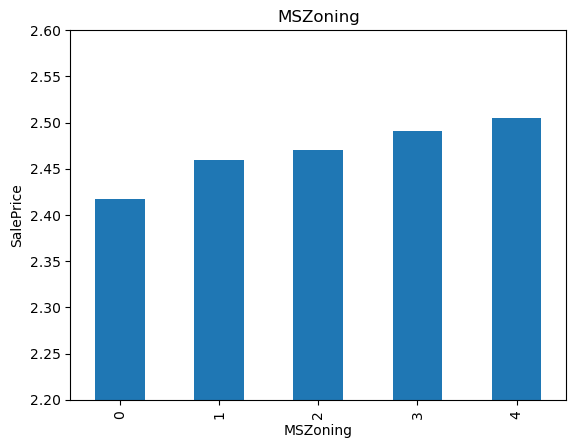

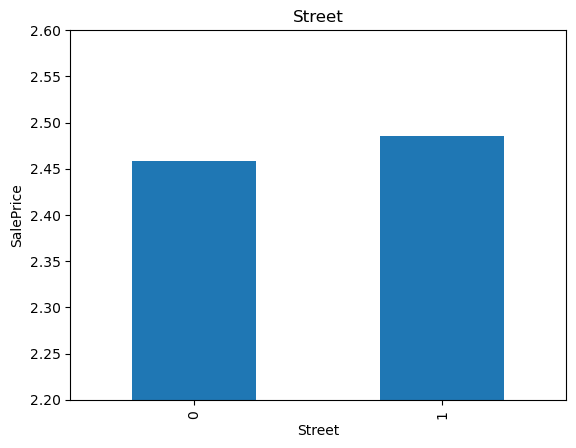

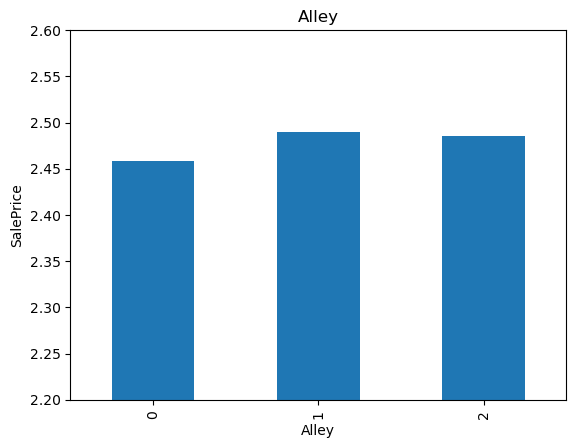

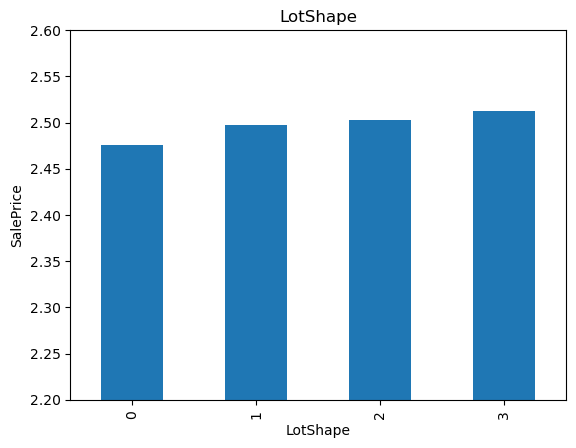

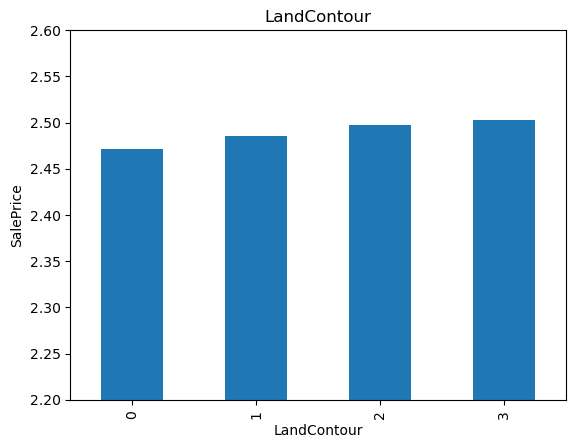

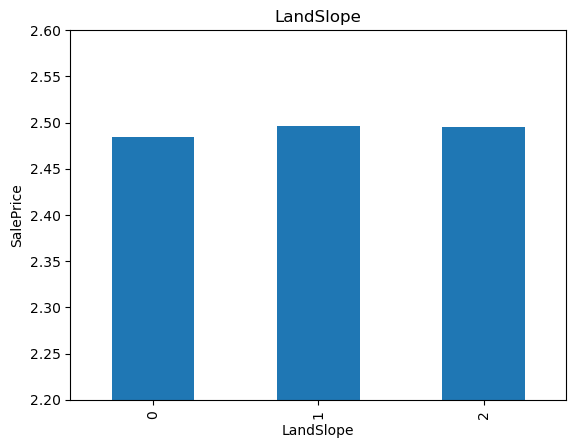

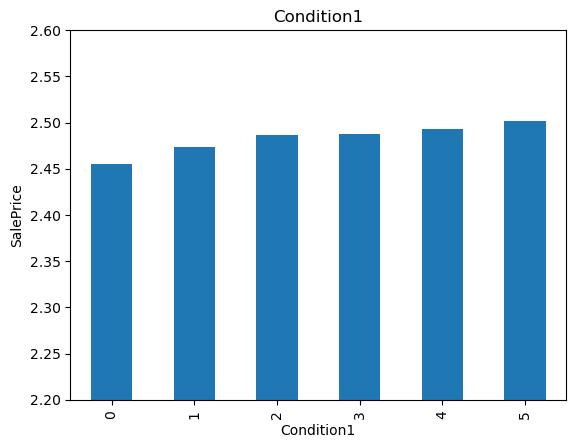

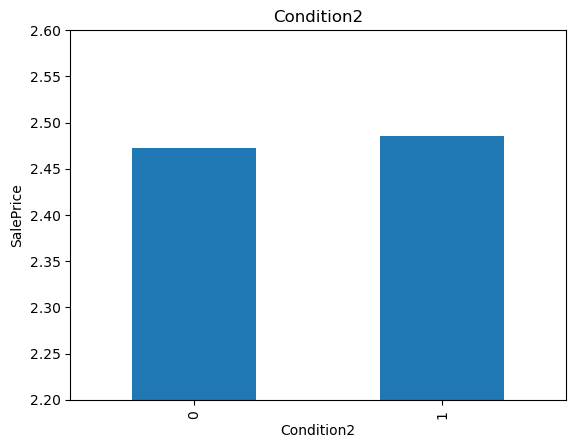

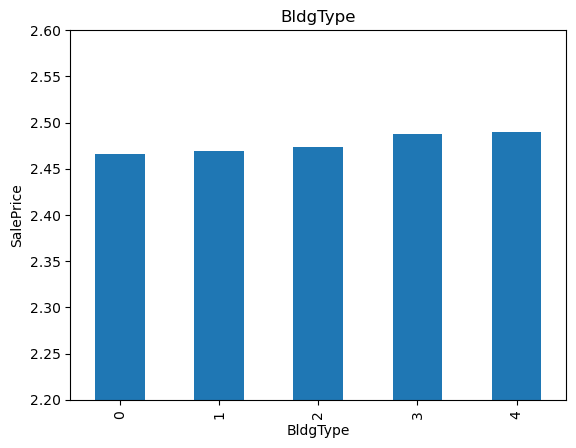

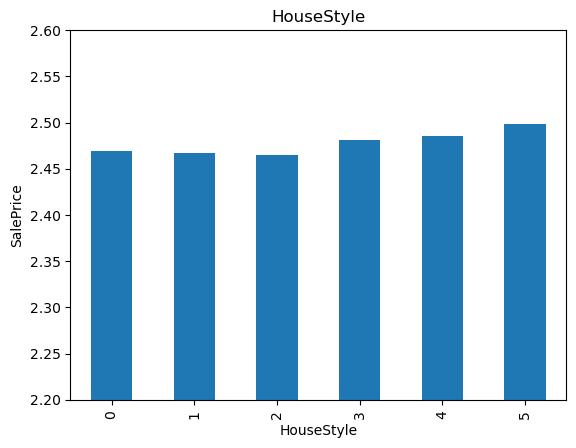

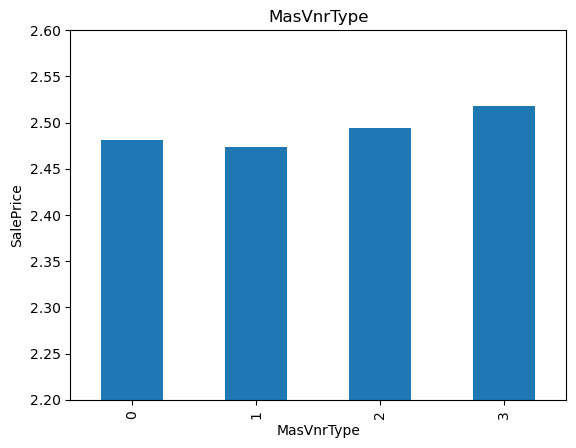

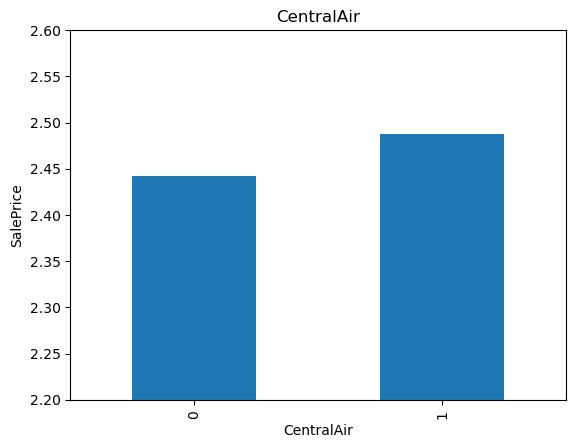

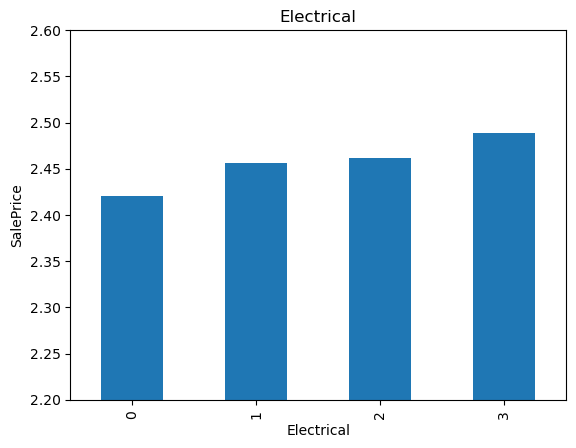

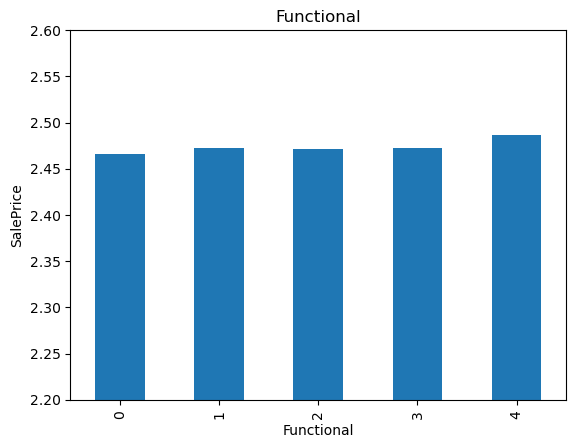

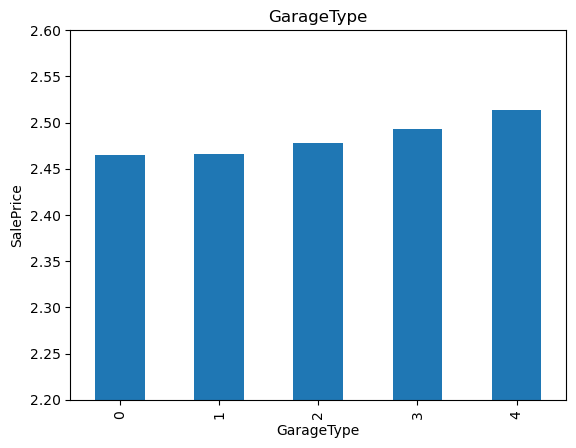

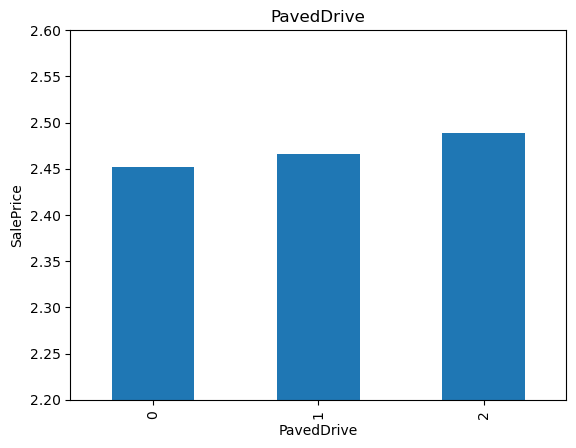

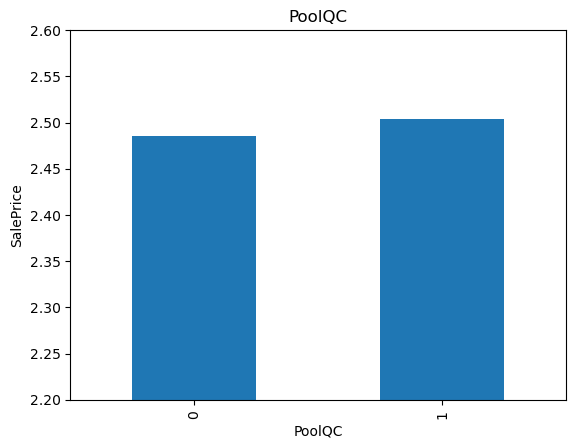

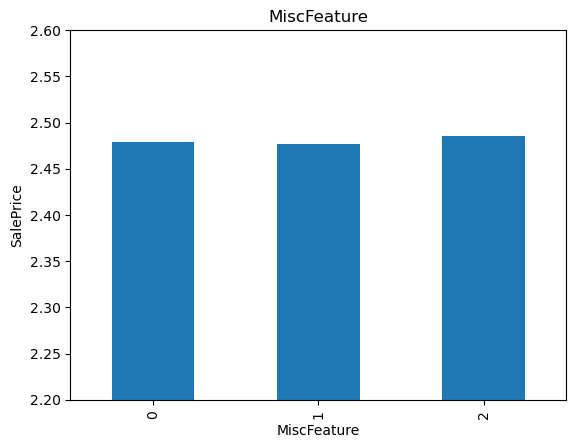

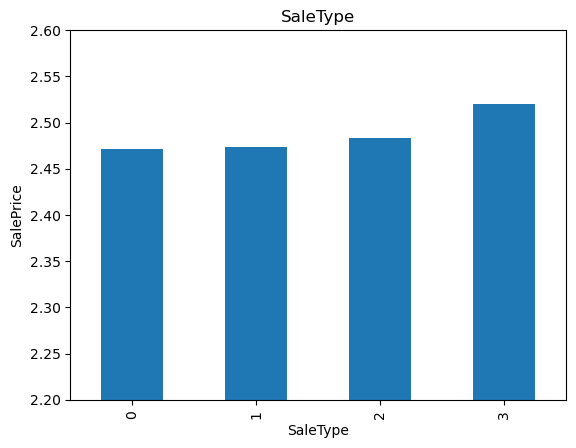

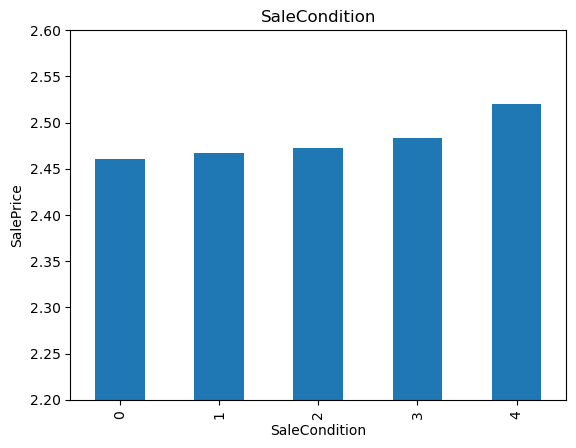

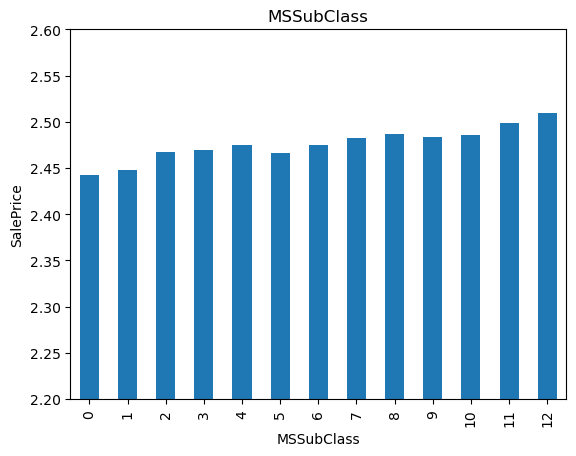

In [41]:
# let me show you what I mean by monotonic relationship
# between labels and target


def analyse_vars(train, ytrain, var):

    # function plots median house sale price per encoded
    # category

    tmp = pd.concat([X_train, np.log(ytrain)], axis=1)

    tmp.groupby(var)["SalePrice"].median().plot.bar()
    plt.title(var)
    plt.ylim(2.2, 2.6)
    plt.ylabel("SalePrice")
    plt.show()


for var in cat_others:
    analyse_vars(X_train, y_train, var)

The monotonic relationship is particularly clear for the variables MSZoning and Neighborhood. The higher the integer that now represents the category, the higher the mean house sale price.

(The target is log-transformed, that is why the differences seem so small).

## Feature Scaling

For use in linear models, features need to be scaled. Scaling features to the minimum and maximum values:

In [42]:
# create scaler
scaler = MinMaxScaler()

#  fit  the scaler to the train set
scaler.fit(X_train)

# transform the train and test set

# sklearn returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)

X_test = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

In [43]:
X_train.head()

MSSubClass  MSZoning  LotFrontage   LotArea  Street  Alley  LotShape  \
0    0.750000      0.75     0.461171  0.366365     1.0    1.0  0.333333   
1    0.750000      0.75     0.456066  0.388528     1.0    1.0  0.333333   
2    0.916667      0.75     0.394699  0.336782     1.0    1.0  0.000000   
3    0.750000      0.75     0.445002  0.482280     1.0    1.0  0.666667   
4    0.750000      0.75     0.577658  0.391756     1.0    1.0  0.333333   

   LandContour  Utilities  LotConfig  LandSlope  Neighborhood  Condition1  \
0     1.000000        1.0        0.0        0.0      0.863636         0.4   
1     0.333333        1.0        0.0        0.0      0.363636         0.4   
2     0.333333        1.0        0.0        0.0      0.954545         0.4   
3     0.666667        1.0        0.0        0.0      0.454545         0.4   
4     0.333333        1.0        0.0        0.0      0.363636         0.4   

   Condition2  BldgType  HouseStyle  OverallQual  OverallCond  YearBuilt  \
0         1.0      0.75         0.6     0.777778         0.50   0.014706   
1         1.0      0.75         0.6     0.444444         0.75   0.360294   
2         1.0      1.00         0.6     0.888889         0.50   0.036765   
3         1.0      0.75         0.6     0.666667         0.50   0.066176   
4         1.0      0.75         0.6     0.555556         0.50   0.323529   

   YearRemodAdd  RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  \
0      0.049180        0.0       0.0          1.0          1.0    0.333333   
1      0.049180        0.0       0.0          0.6          0.6    0.666667   
2      0.098361        1.0       0.0          0.3          0.2    0.666667   
3      0.163934        0.0       0.0          1.0          1.0    0.333333   
4      0.737705        0.0       0.0          0.6          0.7    0.666667   

   MasVnrArea  ExterQual  ExterCond  Foundation  BsmtQual  BsmtCond  \
0     0.00000   0.666667        0.5         1.0  0.666667  0.666667   
1     0.03375   0.666667        0.5         0.5  0.333333  0.666667   
2     0.25750   1.000000        0.5         1.0  1.000000  0.666667   
3     0.00000   0.666667        0.5         1.0  0.666667  0.666667   
4     0.17000   0.333333        0.5         0.5  0.333333  0.666667   

   BsmtExposure  BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  \
0      0.666667           1.0    0.002835           0.0         0.0   
1      0.000000           0.8    0.142807           0.0         0.0   
2      0.000000           1.0    0.080794           0.0         0.0   
3      1.000000           1.0    0.255670           0.0         0.0   
4      0.000000           0.6    0.086818           0.0         0.0   

   BsmtUnfSF  TotalBsmtSF  Heating  HeatingQC  CentralAir  Electrical  \
0   0.673479     0.239935      1.0       1.00         1.0         1.0   
1   0.114724     0.172340      1.0       1.00         1.0         1.0   
2   0.601951     0.286743      1.0       1.00         1.0         1.0   
3   0.018114     0.242553      1.0       1.00         1.0         1.0   
4   0.434278     0.233224      1.0       0.75         1.0         1.0   

   1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
0  0.559760       0.0           0.0   0.523250      0.000000           0.0   
1  0.434539       0.0           0.0   0.406196      0.333333           0.0   
2  0.627205       0.0           0.0   0.586296      0.333333           0.0   
3  0.566920       0.0           0.0   0.529943      0.333333           0.0   
4  0.549026       0.0           0.0   0.513216      0.000000           0.0   

   FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  TotRmsAbvGrd  \
0  0.666667       0.0         0.375      0.333333     0.666667      0.416667   
1  0.333333       0.5         0.375      0.333333     0.666667      0.250000   
2  0.666667       0.0         0.250      0.333333     1.000000      0.333333   
3  0.666667       0.0         0.375      0.333333     0.666667      0.250000   
4

In [44]:
# Save the train and test sets for the next notebook!

X_train.to_csv(f"{data_path}/xtrain.csv", index=False)
X_test.to_csv(f"{data_path}/xtest.csv", index=False)

y_train.to_csv(f"{data_path}/ytrain.csv", index=False)
y_test.to_csv(f"{data_path}/ytest.csv", index=False)

In [45]:
# now let's save the scaler

joblib.dump(scaler, f"{data_path}/minmax_scaler.joblib")

['./datasets/minmax_scaler.joblib']